In [1]:
! python3 -m pip install --upgrade pip
! python3 -m pip install  --upgrade SpeechRecognition
! python3 -m pip install  --upgrade pydub
! python3 -m pip install  --upgrade sklearn

     |████████████████████████████████| 1.5 MB 1.6 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.4
    Uninstalling pip-20.2.4:
      Successfully uninstalled pip-20.2.4
     |████████████████████████████████| 32.8 MB 29 kB/s  eta 0:00:01     |███████████▉                    | 12.2 MB 6.5 MB/s eta 0:00:04     |███████████████████████▊        | 24.3 MB 9.1 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=f712180d1822d3f130f14b0b595de718a95ae41be780e242d7acf986acaca64c
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn


In [2]:
import IPython.display as ipd
import librosa
import librosa.display
import kapre
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import pandas as pd
import random
import re
import shutil
import speech_recognition as sr
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from os import path
from plotnine import *
from pydub import AudioSegment
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Transcribe audio data to txt data

In [4]:
# TODO make an input from user
data_path = '/tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train'

audio_path_cc = data_path + '/Full_wave_enhanced_audio/cc/'
audio_path_cd = data_path + '/Full_wave_enhanced_audio/cd/'


text_path_cc = data_path + '/transcription/cc/'
text_path_cd = data_path + '/transcription/cd/'

lang_ = 'en-US'

r = sr.Recognizer()

In [5]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()

meta['ID'] = meta['ID'].str.strip()

meta

,index,ID,Age,Gender,MMSE,Group
0,0,S001,74,male,NA,cc
1,1,S002,62,female,30,cc
2,2,S003,69,female,29,cc
3,3,S004,71,female,30,cc
4,4,S005,74,female,30,cc
...,...,...,...,...,...,...
103,49,S150,58,male,20,cd
104,50,S151,72,male,24,cd
105,51,S153,68,female,12,cd
106,52,S154,65,female,20,cd


In [6]:
sum(meta.MMSE == ' NA')

1

In [7]:
# Replace all NAs
meta.MMSE = pd.to_numeric(meta.MMSE.replace(' NA', 30))

# TODO - see if this works - Replace all scores in cc group to 30
meta.loc[meta['Group'] == 'cc', 'MMSE'] = 30
meta

,index,ID,Age,Gender,MMSE,Group
0,0,S001,74,male,30,cc
1,1,S002,62,female,30,cc
2,2,S003,69,female,30,cc
3,3,S004,71,female,30,cc
4,4,S005,74,female,30,cc
...,...,...,...,...,...,...
103,49,S150,58,male,20,cd
104,50,S151,72,male,24,cd
105,51,S153,68,female,12,cd
106,52,S154,65,female,20,cd


In [8]:
meta.dtypes

index      int64
ID        object
Age        int64
Gender    object
MMSE       int64
Group     object
dtype: object

In [9]:
def startConversion(path, filename, lang = lang_):
                
    # Create output file name
    output_dir = path + 'output_text/'
    output_file = '.'.join(filename.split(sep='.')[:-1]) + '.txt'
    output_file_path = output_dir + output_file
    
    # If output file does not exist, continue
    if os.path.exists(output_file_path):
        print("Sorry, " + output_file_path + " already exists")
    else:
        full_path = path + filename

        with sr.AudioFile(full_path) as source:
            print('Transcribing file: ' + str(filename) + ' in path: ' + str(full_path))
            audio_text = r.listen(source)
            # recognize_() method will throw a request error if the API is unreachable, hence using exception handling
            try:

                # using google speech recognition
                # print('Converting audio transcripts into text ...')
                text = r.recognize_google(audio_text)

                # Create output directory
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)

                with open(output_file_path, 'w') as f:
                    f.write(text)
                print('Finished transcribing text file ' + str(output_file) + ' at location ' + output_file_path)

            except Exception as e:
                print('Error: ' + str(e) + ' <- this guy')

In [10]:
# Running for CC path
onlyfiles = [f for f in listdir(audio_path_cc) if isfile(join(audio_path_cc, f))]

# Creating this for reference later
audio_cc_text_path = audio_path_cc + 'output_text/'

for filename in onlyfiles:
    startConversion(path = audio_path_cc, filename = filename)

Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/output_text/S001.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/output_text/S002.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/output_text/S003.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/output_text/S004.txt already exists
Transcribing file: S005.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/S005.wav
Error:  <- this guy
Transcribing file: S006.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/S006.wav
Error:  <- this guy
Transcribing file: S007.wav in path: /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cc/S007.wav

In [11]:
# Running for CD path
onlyfiles = [f for f in listdir(audio_path_cd) if isfile(join(audio_path_cd, f))]

# Creating this for reference later
audio_cd_text_path = audio_path_cd + 'output_text/'

for filename in onlyfiles:
    startConversion(path = audio_path_cd, filename = filename)

Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/output_text/S079.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/output_text/S080.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/output_text/S081.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/output_text/S082.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/output_text/S083.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/output_text/S084.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/output_text/S086.txt already exists
Sorry, /tf/dementia/0extra/ADReSS-IS2020-train/A

In [12]:
text_dict = {"ID": [], "Text": []}

# CC path
onlytextfiles_cc = [f for f in listdir(audio_cc_text_path) if isfile(join(audio_cc_text_path, f))]
        
for filename in onlytextfiles_cc:
    just_name = filename.split(sep='.')[:-1][0]
    # print("Adding to dictionary: " + str(just_name))
    full_text_file_path = audio_cc_text_path + filename

    # Make all text lowercase
    # Remove special characters
    with open(full_text_file_path, "r") as file:
        data = file.read().replace('\n', '')
        text_dict["ID"].append(just_name)
        text_dict["Text"].append(data)

# CD path
onlytextfiles_cd = [f for f in listdir(audio_cd_text_path) if isfile(join(audio_cd_text_path, f))]

for filename in onlytextfiles_cd:
    just_name = filename.split(sep='.')[:-1][0]
    # print("Adding to dictionary: " + just_name)
    full_text_file_path = audio_cd_text_path + filename

    # Make all text lowercase
    # Remove special characters
    with open(full_text_file_path, "r") as file:
        data = file.read().replace('\n', '')
        text_dict["ID"].append(just_name)
        text_dict["Text"].append(data)

print("Done!")

Done!


In [13]:
# Convert the dictionary into DataFrame 
text_df = pd.DataFrame(text_dict)
text_df

,ID,Text
0,S001,tell me everything that you see going on in th...
1,S002,picture
2,S003,okay there is a little boy and he's getting he...
3,S004,Homedics laugh you ready well the sink is over...
4,S009,boy is taking cookies from the cookie jar givi...
...,...,...
97,S151,everything that you see happening in that pict...
98,S153,and tell me everything that you see happening ...
99,S154,okay and the boys getting in the cookie jar is...
100,S156,can you tell me now this one is in the cookie ...


In [14]:
merged_data = pd.merge(meta, text_df, on = "ID", how = "inner")
merged_data

,index,ID,Age,Gender,MMSE,Group,Text
0,0,S001,74,male,30,cc,tell me everything that you see going on in th...
1,1,S002,62,female,30,cc,picture
2,2,S003,69,female,30,cc,okay there is a little boy and he's getting he...
3,3,S004,71,female,30,cc,Homedics laugh you ready well the sink is over...
4,7,S009,67,male,30,cc,boy is taking cookies from the cookie jar givi...
...,...,...,...,...,...,...,...
96,49,S150,58,male,20,cd,now the boy on the chair is falling reaching u...
97,50,S151,72,male,24,cd,everything that you see happening in that pict...
98,51,S153,68,female,12,cd,and tell me everything that you see happening ...
99,52,S154,65,female,20,cd,okay and the boys getting in the cookie jar is...


### Making some relevant columns categorical

In [15]:
# Make dummy categorical values and remove redundant first column
merged_data = pd.get_dummies(merged_data, columns=['Gender', 'Group'], drop_first=True)
merged_data

,index,ID,Age,MMSE,Text,Gender_ male,Group_cd
0,0,S001,74,30,tell me everything that you see going on in th...,1,0
1,1,S002,62,30,picture,0,0
2,2,S003,69,30,okay there is a little boy and he's getting he...,0,0
3,3,S004,71,30,Homedics laugh you ready well the sink is over...,0,0
4,7,S009,67,30,boy is taking cookies from the cookie jar givi...,1,0
...,...,...,...,...,...,...,...
96,49,S150,58,20,now the boy on the chair is falling reaching u...,1,1
97,50,S151,72,24,everything that you see happening in that pict...,1,1
98,51,S153,68,12,and tell me everything that you see happening ...,0,1
99,52,S154,65,20,okay and the boys getting in the cookie jar is...,0,1


# Reduce output labels by bucketizing

Reference: https://pubmed.ncbi.nlm.nih.gov/16473978/
MMSE ranges:
* 30 for no
* 26-29 for questionable
* 21-25 for mild
* 11-20 for moderate
* 0-10 for severe dementia

In [43]:
# Set a default value
merged_data['dementia_stage_num'] = 0
merged_data['dementia_stage_text'] = 'None'

In [44]:
# Set dementia stage value for all row indexes which MMSE are in certain ranges

# Mild stage
merged_data['dementia_stage_num'][(merged_data['MMSE'] > 20) & (merged_data['MMSE'] < 30)] = 1
merged_data['dementia_stage_text'][(merged_data['MMSE'] > 20) & (merged_data['MMSE'] < 30)] = 'Mild'

# Moderate/Severe stage
merged_data['dementia_stage_num'][(merged_data['MMSE'] < 21)] = 2
merged_data['dementia_stage_text'][(merged_data['MMSE'] < 21)] = 'Moderate/Severe'

merged_data

,index,ID,Age,MMSE,Text,Gender_ male,Group_cd,dementia_stage_num,dementia_stage_text
0,0,S001,74,30,tell me everything that you see going on in th...,1,0,0,None
1,1,S002,62,30,picture,0,0,0,None
2,2,S003,69,30,okay there is a little boy and he's getting he...,0,0,0,None
3,3,S004,71,30,Homedics laugh you ready well the sink is over...,0,0,0,None
4,7,S009,67,30,boy is taking cookies from the cookie jar givi...,1,0,0,None
...,...,...,...,...,...,...,...,...,...
96,49,S150,58,20,now the boy on the chair is falling reaching u...,1,1,2,Moderate/Severe
97,50,S151,72,24,everything that you see happening in that pict...,1,1,1,Mild
98,51,S153,68,12,and tell me everything that you see happening ...,0,1,2,Moderate/Severe
99,52,S154,65,20,okay and the boys getting in the cookie jar is...,0,1,2,Moderate/Severe


In [45]:
# See number of each type
print(merged_data['dementia_stage_num'].value_counts())

0    51
2    39
1    11
Name: dementia_stage_num, dtype: int64


## Vectorize test data

In [46]:
# Vectorize text data so model can take it in
# TODO make it so english is not hardcoded, flexible for all languages
# https://www.justintodata.com/logistic-regression-example-in-python/
# https://stackoverflow.com/questions/45961747/append-tfidf-to-pandas-dataframe
vectorizer = TfidfVectorizer()
vectorized_text = vectorizer.fit_transform(merged_data['Text'])
vectorizedTextDF = pd.DataFrame(vectorized_text.toarray(), columns=vectorizer.get_feature_names())
print(vectorizedTextDF)

      10  104  303   40    about  acting  action  active  ahead       all  \
0    0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
1    0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
2    0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.081485   
3    0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
4    0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.171352   
..   ...  ...  ...  ...      ...     ...     ...     ...    ...       ...   
96   0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
97   0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
98   0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   
99   0.0  0.0  0.0  0.0  0.17899     0.0     0.0     0.0    0.0  0.000000   
100  0.0  0.0  0.0  0.0  0.00000     0.0     0.0     0.0    0.0  0.000000   

     ...      with  woman   working  yard  year  yet       you  young  \
0 

### Get model columns only

In [47]:
merged_data_useful_cols = merged_data[["Age", "Gender_ male "]]
X_data = pd.concat([merged_data_useful_cols, vectorizedTextDF], axis=1)

# TODO, make binary classifier first? e.g. has or does not have
y_data = merged_data[["dementia_stage_num"]]

In [48]:
X_data

,Age,Gender_ male,10,104,303,40,about,acting,action,active,...,with,woman,working,yard,year,yet,you,young,youngster,your
0,74,1,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.208362,0.0,0.000000,0.0,0.0,0.0,0.164697,0.0,0.0,0.000000
1,62,0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,69,0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.274953,0.0,0.000000,0.0,0.0,0.0,0.048296,0.0,0.0,0.000000
3,71,0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.100045,0.0,0.0,0.000000
4,67,1,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,58,1,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.220035
97,72,1,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.239497,0.0,0.0,0.0,0.241061,0.0,0.0,0.000000
98,68,0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.159917,0.0,0.0,0.000000
99,65,0,0.0,0.0,0.0,0.0,0.17899,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000


In [49]:
y_data

,dementia_stage_num
0,0
1,0
2,0
3,0
4,0
...,...
96,2
97,1
98,2
99,2


# Split dataset

In [50]:
# dividing X, y into train and test data 
# 80/20 training/test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2)
print("Training data set is length: " +str(len(y_train)))
print("Test data set is length: " +str(len(y_test)))

Training data set is length: 80
Test data set is length: 21


# Train and predict on Logistic regression

In [52]:
# all parameters not specified are set to their defaults
# TODO change max_iter value to higher one?
logisticRegr = LogisticRegression(max_iter = 10000)
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
param_values = {
                'penalty' : ['l1', 'l2'],
                'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]                
           }

# Try out the different n_estimators parameters
grid_search_cv = GridSearchCV(estimator = logisticRegr, param_grid = param_values, cv = None, scoring = 'accuracy') 
# A value of 'None' for cv causes this method to evaluate performance by 5-fold cross-validation

In [54]:
grid_search_cv.fit(X_train, y_train)

best_lr_C_value = grid_search_cv.best_params_['C']
best_penalty_value = grid_search_cv.best_params_['penalty']

print("Best C: " + str(best_lr_C_value) + ", best penalty: " + str(best_penalty_value))

Best C: 0.5, best penalty: l2


In [55]:
# Create a model with the best n_estimators value
lr_model = LogisticRegression(max_iter = 10000, penalty=best_penalty_value,C=best_lr_C_value)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

print(classification_report(lr_pred, y_test))

              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.00      0.00      0.00         0
           2       0.20      0.17      0.18         6

    accuracy                           0.48        21
   macro avg       0.30      0.26      0.27        21
weighted avg       0.55      0.48      0.51        21



In [56]:
print("Accuracy: ", accuracy_score(y_test, lr_pred))

Accuracy:  0.47619047619047616


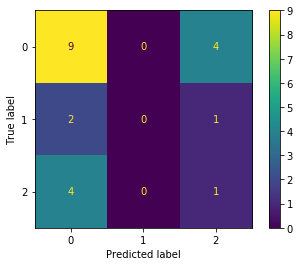

In [57]:
# Create and show confusion matrix
plot_confusion_matrix(lr_model, X_test, y_test)
plt.show()  

# SVM multi class classification based on stage

In [58]:
# Should be same data
# 'OVO' gets better results for some reason
# Linear kernel gets better results for some reason
clf = SVC(decision_function_shape='ovo')
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [59]:
param_values = {
                'C': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000],
                'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']
           }

# Try out the different n_estimators parameters
grid_search_cv = GridSearchCV(estimator = clf, param_grid = param_values, cv = None, scoring = 'accuracy') 
# A value of 'None' for cv causes this method to evaluate performance by 5-fold cross-validation

In [60]:
grid_search_cv.fit(X_train, y_train)

best_svm_C_value = grid_search_cv.best_params_['C']
best_kernel_value = grid_search_cv.best_params_['kernel']

print("Best C: " + str(best_svm_C_value) + ", best kernel: " + str(best_kernel_value))

Best C: 2, best kernel: linear


In [61]:
# Create a model with the best n_estimators value
svm_model = SVC(C=best_svm_C_value, decision_function_shape='ovo', kernel=best_kernel_value);
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

print(classification_report(svm_pred, y_test))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62        13
           1       0.00      0.00      0.00         0
           2       0.40      0.25      0.31         8

    accuracy                           0.48        21
   macro avg       0.34      0.29      0.31        21
weighted avg       0.53      0.48      0.50        21



In [62]:
print("Accuracy: ", accuracy_score(y_test, svm_pred))

Accuracy:  0.47619047619047616


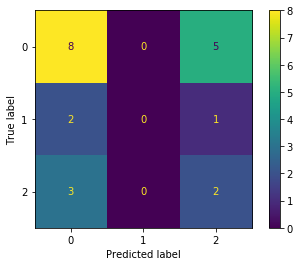

In [63]:
# Create and show confusion matrix
plot_confusion_matrix(svm_model, X_test, y_test)
plt.show()  

# Random forest classifier

In [64]:
# creating a RF classifier 
random_forest = RandomForestClassifier()   
  
# Training the model on the training dataset 
# fit function is used to train the model using the training sets as parameters 
random_forest.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [65]:
n_estimators_values = {'n_estimators': [10, 20, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

# Try out the different n_estimators parameters
grid_search_cv = GridSearchCV(estimator = random_forest, param_grid = n_estimators_values, cv = None, scoring = 'accuracy') 
# A value of 'None' for cv causes this method to evaluate performance by 5-fold cross-validation

In [66]:
grid_search_cv.fit(X_train, y_train)

best_n_estimators = grid_search_cv.best_params_['n_estimators']
best_n_estimators

1000

In [67]:
# Create a model with the best n_estimators value
rf_model = RandomForestClassifier(n_estimators = best_n_estimators);
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_predict_proba = rf_model.predict_proba(X_test)

print(classification_report(rf_pred, y_test))

              precision    recall  f1-score   support

           0       0.85      0.79      0.81        14
           1       0.00      0.00      0.00         0
           2       0.60      0.43      0.50         7

    accuracy                           0.67        21
   macro avg       0.48      0.40      0.44        21
weighted avg       0.76      0.67      0.71        21



In [68]:
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, rf_pred)) 

ACCURACY OF THE MODEL:  0.6666666666666666


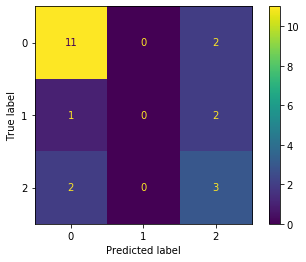

In [69]:
# Create and show confusion matrix
plot_confusion_matrix(rf_model, X_test, y_test)
plt.show()  

# Neural net

In [70]:
# Create a default model to track the best model
best_model =  MLPClassifier(hidden_layer_sizes = (1,), max_iter = 1000);
best_model.fit(X_train, y_train)
best_score = best_model.score(X_test, y_test)
best_hidden_layer_size = (1,)

# Create a neural net model with one hidden layer, iterating through hidden layer sizes
for hidden_layer_size in range(1, 100):
    model = MLPClassifier(hidden_layer_sizes = (hidden_layer_size,), max_iter = 1000);
    model.fit(X_train, y_train)
    model_score = model.score(X_test, y_test)
    
    if model_score > best_score:
        best_model = model;
        best_score = model_score
        best_hidden_layer_size = (hidden_layer_size, )
    
# Print the classification report for the best NN model that we have come up with
mlp_model = best_model
mlp_pred = mlp_model.predict(X_test)

print("The hidden layer size of our best-performing neural network in this experiment is: " + str(best_hidden_layer_size))
print(classification_report(mlp_pred, y_test))

The hidden layer size of our best-performing neural network in this experiment is: (3,)
              precision    recall  f1-score   support

           0       0.92      0.75      0.83        16
           1       0.00      0.00      0.00         0
           2       0.60      0.60      0.60         5

    accuracy                           0.71        21
   macro avg       0.51      0.45      0.48        21
weighted avg       0.85      0.71      0.77        21



In [71]:
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, mlp_pred))

ACCURACY OF THE MODEL:  0.7142857142857143


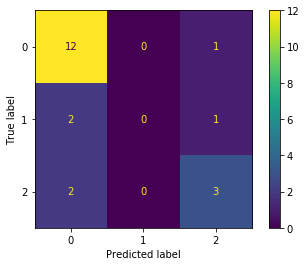

In [72]:
# Create and show confusion matrix
plot_confusion_matrix(mlp_model, X_test, y_test)
plt.show()  

# Chain models

In [73]:
def create_stacked():
    estimators = [
        ('rf',  RandomForestClassifier(n_estimators=best_n_estimators)),
        ('svm', SVC(C = best_svm_C_value, decision_function_shape='ovo', kernel=best_kernel_value)),
        ('nn', MLPClassifier(hidden_layer_sizes = best_hidden_layer_size, max_iter = 1000)),
        ('lr', LogisticRegression(C=best_lr_C_value, penalty=best_penalty_value))
    ]
    return StackingClassifier(estimators=estimators)

clf = create_stacked()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.62      0.67      0.64        12
           1       0.00      0.00      0.00         0
           2       0.40      0.22      0.29         9

    accuracy                           0.48        21
   macro avg       0.34      0.30      0.31        21
weighted avg       0.52      0.48      0.49        21



In [74]:
# using metrics module for accuracy calculation 
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, pred))

ACCURACY OF THE MODEL:  0.47619047619047616


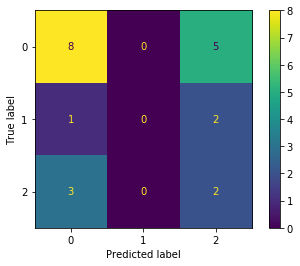

In [75]:
# Create and show confusion matrix
plot_confusion_matrix(clf, X_test, y_test)
plt.show()  